# Recommendation Systems Assignment

### MIE451/1513 UofT

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [ ]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import wget
import matplotlib.pyplot as plt

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=5d903ffb9d393bdb7326a945c1843b0efda38b52bce1829702243c6348d9aec0
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


## Support functions and variables

In [ ]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")

'ml-100k.zip'

In [ ]:
!unzip ml-100k.zip

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [ ]:
MOVIELENS_DIR = "ml-100k"

In [ ]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [ ]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data

In [ ]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [ ]:
rating_df_train = getData(MOVIELENS_DIR, 'u1.base')
rating_df_test = getData(MOVIELENS_DIR, 'u1.test')

In [ ]:
rating_df_train.head()

,userID,itemID,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [ ]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [ ]:
print("Number of users in rating df:", len(rating_df.userID.unique()))
print("Number of items in rating df:", len(rating_df.itemID.unique()))
print("Number of users in train df:", len(rating_df_train.userID.unique()))
print("Number of items in train df:", len(rating_df_train.itemID.unique()))
print("Number of users in test df:", len(rating_df_test.userID.unique()))
print("Number of items in test df:", len(rating_df_test.itemID.unique()))

Number of users in rating df: 943
Number of items in rating df: 1682
Number of users in train df: 943
Number of items in train df: 1650
Number of users in test df: 459
Number of items in test df: 1410


## Q1

### (a)

In [ ]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT:
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items

        OUTPUT:
            matrix: 2D numpy array.

        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'

        NOTE 2: data can have more columns, but your function should ignore
              additional columns.
    """
    ########### your code goes here ###########
    matrix = np.zeros((num_users, num_items), dtype=np.int8)

    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
    ###########         end         ###########
    return matrix

In [ ]:
a = dataPreprocessor(rating_df,  len(rating_df.userID.unique()),  len(rating_df.itemID.unique()))
print(a.shape)

(943, 1682)


In [ ]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name

    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }

        return switcher[method_name]

    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.

            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'
        """

        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                # select the row for user
                # what's the shape of userVector
                userVector = train_matrix[user, :]

                # Extract the items the user already rated
                ratedItems = userVector[userVector.nonzero()]

                # If not empty, calculate average and set as rating for the current item
                if ratedItems.size == 0:
                    itemAvg = 0
                else:
                    itemAvg = ratedItems.mean()
                predictionMatrix[user, item] = itemAvg

            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))
        ###########         end         ###########
        return predictionMatrix

    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.

            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'
        """

        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated

        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                predictionMatrix[user, item] = itemPopularity[item]

            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))
        ###########         end         ###########
        return predictionMatrix

    def predict_all(self, train_df, num_users, num_items):

        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)

    def evaluate_test(self, test_df, copy=False):

        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df

        prediction[self.pred_column_name] = np.nan

        for (index,
             userID,
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction

    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model

    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name

    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")


In [ ]:
popularity_recsys = BaseLineRecSys('popularity')

In [ ]:
popularity_recsys.predict_all(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [ ]:
x = popularity_recsys.getModel()

In [ ]:
x

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.38095238, 0.37333333, ..., 0.        , 0.        ,
        0.        ],
       [0.71018277, 0.38095238, 0.37333333, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.38095238, 0.37333333, ..., 0.        , 0.        ,
        0.        ],
       [0.71018277, 0.38095238, 0.37333333, ..., 0.        , 0.        ,
        0.        ],
       [0.71018277, 0.        , 0.37333333, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
np.all(x<=1)

True

In [ ]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [ ]:
popularity_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:03, 5049.12it/s]


,userID,itemID,rating,timestamp,popularity
0,1,6,5,887431973,0.500000
1,1,10,3,875693118,0.698630
2,1,12,5,878542960,0.872038
3,1,14,5,874965706,0.685714
4,1,17,3,875073198,0.472222


In [ ]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [ ]:
average_user_rating_recsys.predict_all(rating_df_train, len(rating_df.userID.unique()), len(rating_df.itemID.unique()))


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [ ]:
average_user_rating_recsys.getModel()

array([[0.        , 0.        , 0.        , ..., 3.68148148, 3.68148148,
        3.68148148],
       [0.        , 3.8       , 3.8       , ..., 3.8       , 3.8       ,
        3.8       ],
       [3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        3.        ],
       ...,
       [0.        , 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 0.        , 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [ ]:
average_user_rating_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:01, 13969.56it/s]


,userID,itemID,rating,timestamp,useraverage
0,1,6,5,887431973,3.681481
1,1,10,3,875693118,3.681481
2,1,12,5,878542960,3.681481
3,1,14,5,874965706,3.681481
4,1,17,3,875073198,3.681481


## Q2

### (a)

In [ ]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name

    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }

        return switcher[method_name]

    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix

    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########
        similarity_matrix = 1 / (1 + pairwise_distances(matrix, metric='euclidean'))
        ###########         end         ###########
        return similarity_matrix

    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
        similarity_matrix = 1 / (1 + pairwise_distances(matrix, metric='manhattan'))
        ###########         end         ###########
        return similarity_matrix

    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model

            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)

        if self.base == 'user':
            ########### your code goes here ###########
            # Initialize the predicted rating matrix with zeros
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix)
            # if k is not None:
            #     uu_similarity = kNearestNeighbor(uu_similarity, k)
            # UxI: UxU mul UxI
            normalizer = np.matmul(uu_similarity, temp_matrix)
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5
            #what's the dimension of np.matmul(uu_similarity, trainSet)

            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no one has rated this item before, use user average
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model = predictionMatrix
            ###########         end         ###########

        elif self.base == 'item':
            ########### your code goes here ###########
            # Initialize the predicted rating matrix with zeros
            train_matrix = train_matrix.transpose()
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            ii_similarity = self.method(train_matrix)
            # if k is not None:
            #     ii_similarity = kNearestNeighbor(ii_similarity, k)
            # UxI: UxU mul UxI
            normalizer = np.matmul(ii_similarity, temp_matrix)
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5
            #what's the dimension of np.matmul(uu_similarity, trainSet)

            predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no one has rated this item before, use user average
            itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)
            predictionMatrix = predictionMatrix.transpose()
            self.__model = predictionMatrix
            ###########         end         ###########
        else:
            print('No other option available')


    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame.
                              columns=['userID', 'itemID', 'rating', 'base-method'...]

            NOTE: 1. data can have more columns, but your function should ignore
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine',
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan

        for (index,
             userID,
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction

    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model

    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name

    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [ ]:
# Examples of how to call similarity functions.
I = np.eye(3)
# I = np.array([[3,0,2, 3],[0,5,3, 4], [3,3,5, 1], [0,5,0, 0], [3,5,0, 3]])
# print(I[[True,False, False, True, True]])

In [ ]:
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [ ]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

I would expect cosine to work better because cosine is better than euclidean for measuring similarity(discussed in lecture). Further, euclidean is prone to outliers, as one rating grows, euclidean distance grows much faster than cosine angle, which is maxed out at 1.

### (b)
I think manhattan distance is good because it measure distance like Euclidean distance, just using l1 norm instead of l2 norm; if we claim Euclidea distance is appropriate, so too should be Manhattan.

##Q3

### (a)

In [ ]:
user_cosine_recsys = SimBasedRecSys('user','cosine')
user_cosine_recsys.predict_all(rating_df_train, len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
user_cosine_recsys.getModel()


array([[3.90764656, 3.18309825, 3.00989335, ..., 2.        , 3.        ,
        3.        ],
       [3.85592514, 3.18240388, 2.89077623, ..., 2.        , 3.        ,
        3.        ],
       [3.87394327, 3.10905007, 3.02102791, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.92534088, 3.20099215, 3.04206385, ..., 2.        , 3.        ,
        3.        ],
       [3.90921865, 3.21359819, 2.9819897 , ..., 2.        , 3.        ,
        3.        ],
       [3.93355541, 3.24681066, 3.05886723, ..., 0.        , 3.        ,
        3.        ]])

In [ ]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [ ]:
user_cosine_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:01, 13663.70it/s]


,userID,itemID,rating,timestamp,user-cosine
0,1,6,5,887431973,3.419572
1,1,10,3,875693118,3.850140
2,1,12,5,878542960,4.400558
3,1,14,5,874965706,3.878056
4,1,17,3,875073198,3.130335


In [ ]:
item_cosine_recsys = SimBasedRecSys('item','cosine')

In [ ]:
item_cosine_recsys.predict_all(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))


<ipython-input-26-a03672383fef>:116: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)


In [ ]:
item_cosine_recsys.getModel()

array([[3.85156994, 3.7342213 , 3.83843022, ..., 4.11798149, 3.90551101,
        3.9598337 ],
       [3.87401875, 3.85300753, 3.82228493, ..., 3.77601163, 3.95744705,
        4.09365253],
       [2.96947266, 3.03381501, 2.94253433, ..., 3.12417711, 3.27065656,
        2.79578581],
       ...,
       [4.11724041, 4.06618477, 4.0274836 , ..., 4.        , 3.88126854,
        4.14874911],
       [4.37234448, 4.42355222, 4.34195687, ..., 3.95265019, 4.41470077,
        4.57717283],
       [3.52291931, 3.4890315 , 3.53459055, ..., 0.        , 3.608216  ,
        3.59916709]])

In [ ]:
item_cosine_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:01, 10971.77it/s]


,userID,itemID,rating,timestamp,item-cosine
0,1,6,5,887431973,4.047083
1,1,10,3,875693118,3.976599
2,1,12,5,878542960,3.889206
3,1,14,5,874965706,4.024444
4,1,17,3,875073198,3.779897


### (b)

In [ ]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)

    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }

        return switcher[metric_name]

    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame.
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))

    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame.
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)

        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions

    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame.
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls

    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))

        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value

        return matrix

    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds

    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms.
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """

        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                # display(prediction.head())
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))

            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]

        results = scores

        return results


In [ ]:
# How to use CrossValidation Class?

In [ ]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [popularity_recsys,
                       average_user_rating_recsys,
                       user_cosine_recsys]

In [ ]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, RPrecision
# Precision at K in this example
cv_patk = CrossValidation('P@K')

In [ ]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_patk.run(algorithm_instances,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 13871.13it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:03, 6632.30it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 14342.44it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:02, 9089.25it/s] 


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 14223.84it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 10272.31it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 10288.46it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 10505.80it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 10451.42it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 10510.83it/s]


Processing algorithm user-cosine


20000it [00:01, 10371.60it/s]
20000it [00:02, 6750.38it/s]
20000it [00:01, 10200.34it/s]
20000it [00:01, 10145.77it/s]
20000it [00:02, 8766.97it/s]


{'popularity': [[0.36924708377518656,
   0.4965005302226948,
   0.6152704135737019,
   0.6426299045599162,
   0.6292682926829279],
  0.5505832449628855,
  0.40544114481568705,
  0.6957253451100839],
 'useraverage': [[0.30604453870625714,
   0.4305408271474029,
   0.5321314952279973,
   0.5520678685047737,
   0.5474019088016986],
  0.4736373276776259,
  0.3419993013451059,
  0.6052753540101459],
 'user-cosine': [[0.37179215270413657,
   0.503923647932133,
   0.621633085896077,
   0.6483563096500541,
   0.6335100742311777],
  0.5558430540827157,
  0.40959849499983714,
  0.7020876131655943]}

In [ ]:
algorithm_instances = [user_cosine_recsys,
                       item_cosine_recsys]
cv_rmse = CrossValidation('RMSE')
cv_rmse.run(algorithm_instances,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)

Processing algorithm user-cosine


20000it [00:01, 13140.11it/s]
20000it [00:01, 13016.90it/s]
20000it [00:01, 12968.57it/s]
20000it [00:01, 13154.96it/s]
20000it [00:01, 13406.83it/s]


Processing algorithm item-cosine


<ipython-input-26-a03672383fef>:116: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:02, 6991.09it/s]
<ipython-input-26-a03672383fef>:116: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:01, 10352.19it/s]
<ipython-input-26-a03672383fef>:116: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:01, 10294.98it/s]
<ipython-input-26-a03672383fef>:116: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:02, 8852.07it/s] 
<ipython-input-26-a03672383fef>:116: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:01, 10494.66it/s]


{'user-cosine': [[1.026449013124381,
   1.0214387664779507,
   1.0132940326457187,
   1.0094003999022945,
   1.0161883961525586],
  1.0173541216605808,
  1.0090130802261479,
  1.0256951630950137],
 'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011795,
   1.0136832839209695,
   1.0180579656376574],
  1.0200829001062477,
  1.006824268625073,
  1.0333415315874224]}

The mean and confidence interval for user-user and item-item similarity-based recommenders (to 3 decimal places) are as follows:

User Cosine:
Mean: 1.017
Confidence Interval: 1.009 - 1.026

Item Cosine:
Mean: 1.020
Confidence Interval: 1.007 - 1.033

User Cosine has a better mean and tighter confidence interval. This is because the average number of ratings per user is more than average number of ratings per item, since there are fewer users than items. As a result, we have more data for user-user comparison and are more confident about our representations of users over items.

##Q4

(a)

## PMF

In [ ]:
import sys
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)

        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item

            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user

        """
        # select 'userID', 'itemID', 'rating only
        train_vec['userID'] = train_vec['userID']
        train_vec['itemID'] = train_vec['itemID']
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating


        # to avoid out of bound
        num_user += 1
        num_item += 1
        # initialize
        self.epoch = 0
        ########### your code goes here ###########
        self.w_Item = 0.1 * np.random.randn(num_item, self.num_feat)
        self.w_User = 0.1 * np.random.randn(num_user, self.num_feat)
        ###########         end         ###########

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch:
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches):
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')


                # Compute mean rating subtracted rating
                ########### your code goes here ###########
                user_embeddings = self.w_User[batch_UserID, :]
                item_embeddings = self.w_Item[batch_ItemID, :]
                pred_out = np.sum(np.multiply(user_embeddings, item_embeddings), axis=1)
                ###########         end         ###########

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')

                    # Compute Compute mean rating subtracted rating
                    ########### your code goes here ###########
                    user_embeddings = self.w_User[train_user_idx, :]
                    item_embeddings = self.w_Item[train_item_idx, :]
                    pred_out = np.sum(np.multiply(user_embeddings, item_embeddings), axis=1)
                    ###########         end         ###########
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2]
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')

                    # Compute Compute mean rating subtracted rating
                    ########### your code goes here ###########
                    user_embeddings = self.w_User[val_user_idx, :]
                    item_embeddings = self.w_Item[val_item_idx, :]
                    pred_out = np.sum(np.multiply(user_embeddings, item_embeddings), axis=1)
                    ###########         end         ###########

                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))





    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame.
                              columns=['userID', 'itemID', 'rating', 'base-method'...]

            NOTE: 1. data can have more columns, but your function should ignore
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine',
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan

        for (index,
             userID,
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]

        return prediction

    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()

    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name

    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None
            self.w_User = None
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)
        else:
          raise Exception("You need to pass in a dictionary")

In [ ]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 100, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})

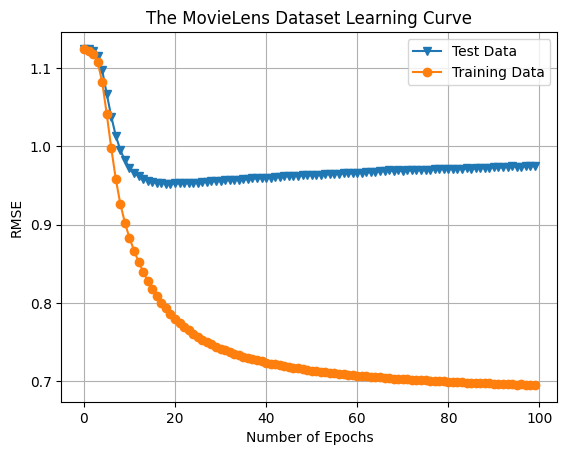

In [ ]:
pmf.predict_all(rating_df,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
pmf.plot_error()

##Q5

### (a)

In [ ]:
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 20, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
pmf.predict_all(rating_df,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

algorithm_instances = [popularity_recsys,
                       average_user_rating_recsys,
                       user_cosine_recsys,
                       item_cosine_recsys,
                       pmf]
cv_rmse = CrossValidation('RMSE')
rmse_results = cv_rmse.run(algorithm_instances,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)
cv_patk = CrossValidation('P@K')
patk_results = cv_patk.run(algorithm_instances,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)
cv_ratk = CrossValidation('R@K')
ratk_results = cv_ratk.run(algorithm_instances,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 13021.54it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 12042.47it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 13463.35it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 13785.76it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 13919.86it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:02, 7682.50it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:02, 8105.96it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:02, 9883.12it/s] 


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 10445.32it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 10375.73it/s]


Processing algorithm user-cosine


20000it [00:01, 10294.67it/s]
20000it [00:02, 8263.81it/s]
20000it [00:02, 9198.39it/s] 
20000it [00:02, 9932.35it/s]
20000it [00:01, 10533.30it/s]


Processing algorithm item-cosine


<ipython-input-26-a03672383fef>:116: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:02, 9990.23it/s] 
<ipython-input-26-a03672383fef>:116: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:02, 9035.50it/s]
<ipython-input-26-a03672383fef>:116: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:02, 8785.26it/s] 
<ipython-input-26-a03672383fef>:116: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:01, 11005.96it/s]
<ipython-input-26-a03672383fef>:116: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:02, 9506.87it/s]


Processing algorithm PMF


20000it [00:03, 5587.98it/s]
20000it [00:03, 5760.30it/s]
20000it [00:03, 5907.35it/s]
20000it [00:03, 5593.63it/s]
20000it [00:03, 5539.92it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 10113.35it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 13656.61it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:02, 7863.92it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 13860.83it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:02, 9887.26it/s] 


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:02, 7638.81it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:02, 9922.80it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 11023.89it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 10692.41it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 11017.99it/s]


Processing algorithm user-cosine


20000it [00:02, 6881.75it/s]
20000it [00:01, 10454.53it/s]
20000it [00:02, 9870.83it/s]
20000it [00:02, 9216.22it/s]
20000it [00:02, 9557.74it/s]


Processing algorithm item-cosine


<ipython-input-26-a03672383fef>:116: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:01, 10107.68it/s]
<ipython-input-26-a03672383fef>:116: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:01, 10592.08it/s]
<ipython-input-26-a03672383fef>:116: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:01, 10287.60it/s]
<ipython-input-26-a03672383fef>:116: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:01, 10272.70it/s]
<ipython-input-26-a03672383fef>:116: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:01, 10916.76it/s]


Processing algorithm PMF


20000it [00:03, 5966.94it/s]
20000it [00:04, 4194.24it/s]
20000it [00:05, 3881.70it/s]
20000it [00:05, 3772.66it/s]
20000it [00:04, 4498.50it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 13727.16it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 14119.26it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 14009.27it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 13637.13it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:02, 9762.74it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:02, 8831.26it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:02, 9858.92it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:02, 9813.41it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 10390.77it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:01, 10340.74it/s]


Processing algorithm user-cosine


20000it [00:02, 9200.31it/s] 
20000it [00:01, 10111.13it/s]
20000it [00:01, 10080.27it/s]
20000it [00:02, 6964.02it/s]
20000it [00:01, 10550.47it/s]


Processing algorithm item-cosine


<ipython-input-26-a03672383fef>:116: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:01, 10433.44it/s]
<ipython-input-26-a03672383fef>:116: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:02, 8942.83it/s]
<ipython-input-26-a03672383fef>:116: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:01, 10213.00it/s]


In [ ]:
from matplotlib.font_manager import MSUserFontDirectories
all_results = {'RMSE': rmse_results, 'P@K': patk_results, 'R@K': ratk_results}
all_results
for metric in all_results:
  print(metric)
  for algorithm in all_results[metric]:
    print(f'\t--{algorithm}--')
    print(f'\tMean: {round(all_results[metric][algorithm][1], 3)}')
    print(f'\tConfidence Interval: {round(all_results[metric][algorithm][2], 3)} - {round(all_results[metric][algorithm][3], 3)}')

### (b)

The popularity metric should not be assessed with the RMSE metric, as it gives each item a probability, as opposed to the rank.

User Average-based scorings should not be used with P@k and R@k because each item is given the same rank.

### (c)
RMSE, P@K, R@K are all optimized by user-cosine method. This makes sense to an extent. User-User similarity is a great way to determine unseen rankings; if a user if very similar to a group of users, ie likes a specific genre, he/she will likely watch similar movies in general. I do expect, however, that further tuning of PMF may improve results.

### (d)
Better RMSE scores imply better ranking. This is because better RMSE implies better scoring, and a better scoring is expected to generalize well across all items, notably including the top ranking ones. However, better ranking does not indicate better RMSE. It is possible to over-score the top k and underscore the rest. In this case, RMSE is low. In general, ranking metrics consider top k only, for a pretty small k, and ignore the rest.

## Q6



### (a)

In [ ]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
moviesDF

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,01-Jan-1995,NaN,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
7,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0
8,9,Dead Man Walking (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Dead%20Man%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9,10,Richard III (1995),22-Jan-1996,NaN,http://us.imdb.com/M/title-exact?Richard%20III...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [ ]:
my_movies = ['GoldenEye (1995)', 'Casper (1995)', 'Twelve Monkeys (1995)']
moviesDF[moviesDF['movieTitle'].isin(my_movies)]

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
6,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
767,768,Casper (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Casper%20(1995),0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_matrix = dataPreprocessor(rating_df,  len(rating_df.userID.unique()),  len(rating_df.itemID.unique()))
ii_similarity = SimBasedRecSys.cosine(train_matrix.transpose())

for movie in my_movies:
  movie_id = moviesDF[moviesDF['movieTitle']==movie]['movieID'].values[0]-1
  print(movie)
  print('Similar Movies:')
  sim_ids = ii_similarity[movie_id].argsort()[-6:-1]
  display(moviesDF[moviesDF['movieID'].isin(sim_ids+1)])


GoldenEye (1995)
Similar Movies:


,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
61,62,Stargate (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Stargate%20(1...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
160,161,Top Gun (1986),01-Jan-1986,NaN,http://us.imdb.com/M/title-exact?Top%20Gun%20(...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
232,233,Under Siege (1992),01-Jan-1992,NaN,http://us.imdb.com/M/title-exact?Under%20Siege...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
384,385,True Lies (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?True%20Lies%2...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
402,403,Batman (1989),01-Jan-1989,NaN,http://us.imdb.com/M/title-exact?Batman%20(1989),0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0


Casper (1995)
Similar Movies:


,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
62,63,"Santa Clause, The (1994)",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Santa%20Claus...,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
77,78,Free Willy (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Free%20Willy%...,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
139,140,Homeward Bound: The Incredible Journey (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Homeward%20Bo...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
392,393,Mrs. Doubtfire (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Mrs.%20Doubtf...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
794,795,Richie Rich (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Richie%20Rich...,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Twelve Monkeys (1995)
Similar Movies:


,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
49,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
55,56,Pulp Fiction (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Pulp%20Fictio...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
99,100,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
116,117,"Rock, The (1996)",07-Jun-1996,NaN,"http://us.imdb.com/M/title-exact?Rock,%20The%2...",0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
180,181,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0


### (b)
I can somewhat justify the results. I would expect similar movies to be of the same genre. The selected movies fall under action, adventure and drama. Of the 5 returned movies, 5/5, 2/5 and 2/5 are of the same genre as the original movie. however, results aren't perfect because people can like more than one genre, each person only rates so many movies, and these movies are not the same across all people.

## Q7

### (a)

In [ ]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

In [ ]:
def plot_embs_one_genre(embeddings, moviesDF, genre, sample_size):
  """
            INPUT:
                embeddings: numpy Array
                moviesDF: pandas DataFrame.
                          columns=['movieID',	'movieTitle',	'releaseDate	video','ReleaseDate',	'IMDbURL',...]
                genre: string. (e.g., 'action', 'comedy', etc.)
                sample_size: int


            OUTPUT:
                None

            NOTE: 1. You can read the file 'u.item' into a pandaas DataFrame for using as moviesDF
  """
  np.random.seed(3)
  genre1_movie_ids = np.random.choice(moviesDF[moviesDF[genre] == 1]['movieID'].values, size = sample_size, replace=False)
  genre1_embeddings = embeddings[genre1_movie_ids]

  genre2_movie_ids = np.random.choice(moviesDF[moviesDF[genre] == 0]['movieID'].values, size = sample_size, replace=False)
  genre2_embeddings = embeddings[genre2_movie_ids]

  all_ids = np.concatenate([genre1_movie_ids, genre2_movie_ids])
  index2id = {i:all_ids[i] for i in range(all_ids.shape[0])}

  all_embeddings = embeddings[all_ids]


  top_indices = np.argpartition(all_embeddings, -3, axis=0)[-3:]

  bottom_indices = np.argpartition(all_embeddings, 3, axis=0)[:3]

  v_offset = 20
  print(genre1_movie_ids)
  for i in range(embeddings.shape[1]):
    plt.close()
    plt.figure()
    plt.scatter(genre1_embeddings[:, i], np.full_like(genre1_movie_ids, i), c='red', label=f'{genre}')
    plt.scatter(genre2_embeddings[:, i], np.full_like(genre2_movie_ids, i), c='blue', label=f'not {genre}')

    # for k, j in enumerate(top_indices[:, i]):
    #   y_offset = k * v_offset
    #   plt.annotate(moviesDF.loc[moviesDF['movieID'] == index2id[j], 'movieTitle'].values[0], (all_embeddings[j, i], i ), xytext=(-2*y_offset, 20+i+y_offset), textcoords='offset points', fontsize=8, color='black', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.3' ,color='black'))

    # for k, j in enumerate(bottom_indices[:, i]):
    #   y_offset = k * v_offset
    #   plt.annotate(moviesDF.loc[moviesDF['movieID'] == index2id[j], 'movieTitle'].values[0], (all_embeddings[j, i], i), xytext=(2*y_offset, -20-i-y_offset), textcoords='offset points', fontsize=8, color='black', arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=0.3', color='black'))

    plt.xlabel('Embedding Value')
    plt.ylabel('Movie ID')
    plt.legend()
    plt.title(f'Dimension {i} Embeddings for {genre} and not {genre} Movies')
    plt.show()



[  73  245 1491  260  881  184   27  101   62  651  326  578  349 1304
  145 1413 1228 1183 1181  636]


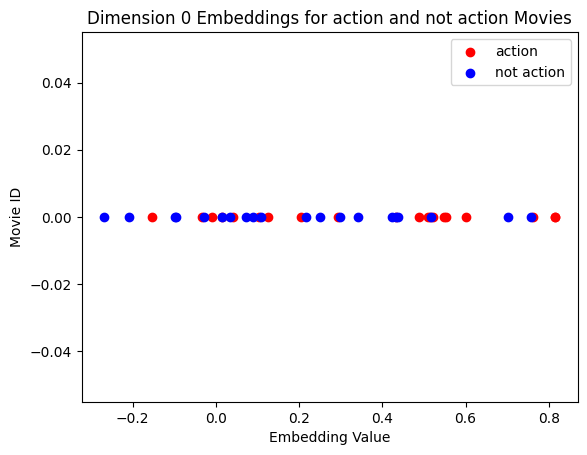

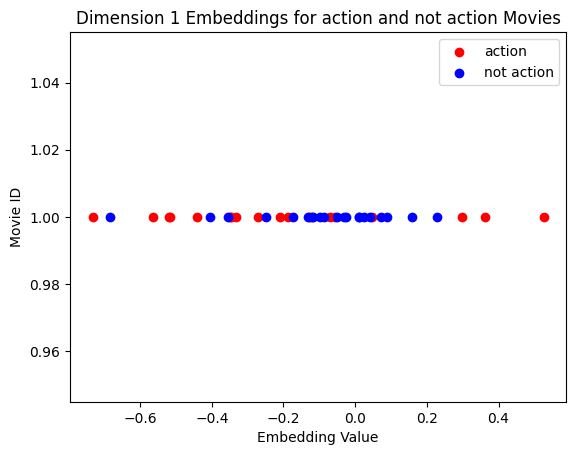

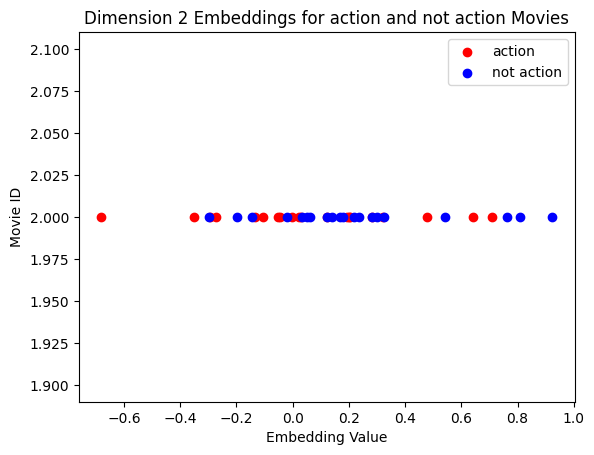

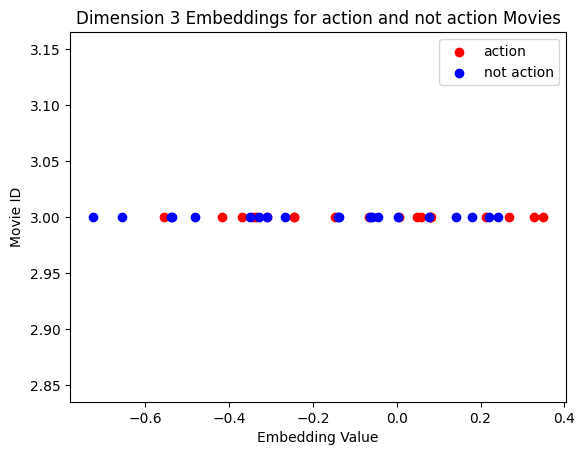

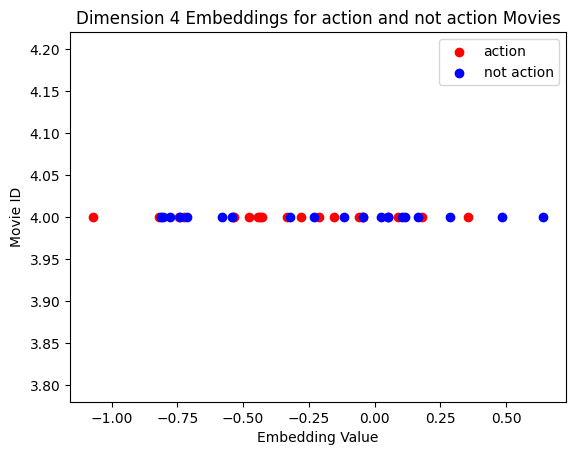

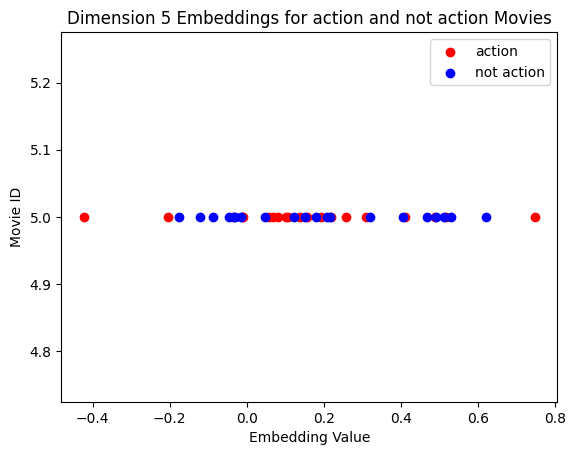

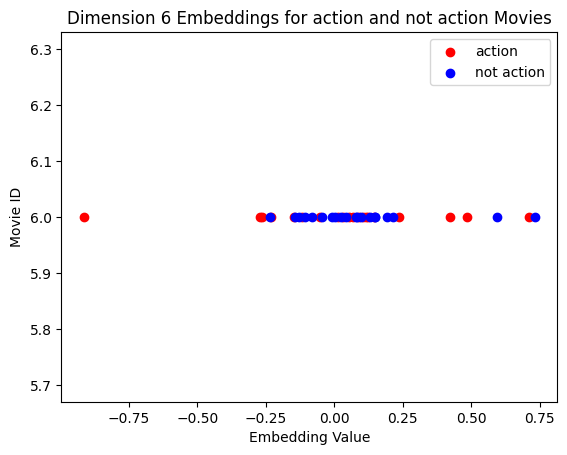

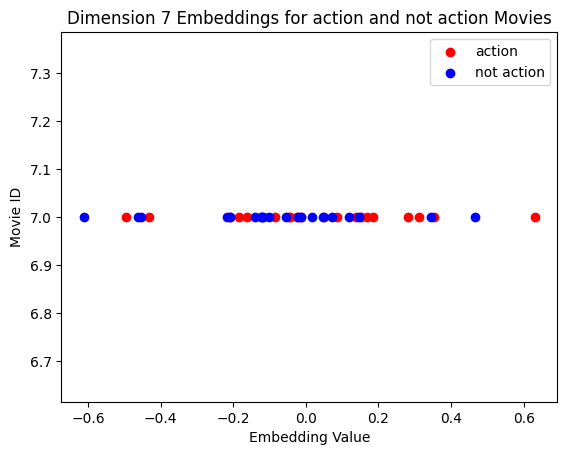

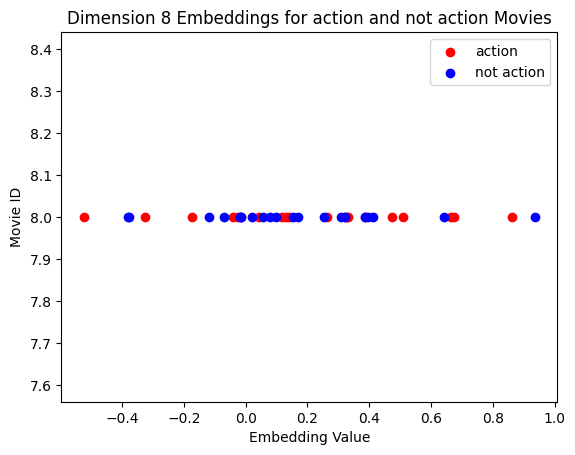

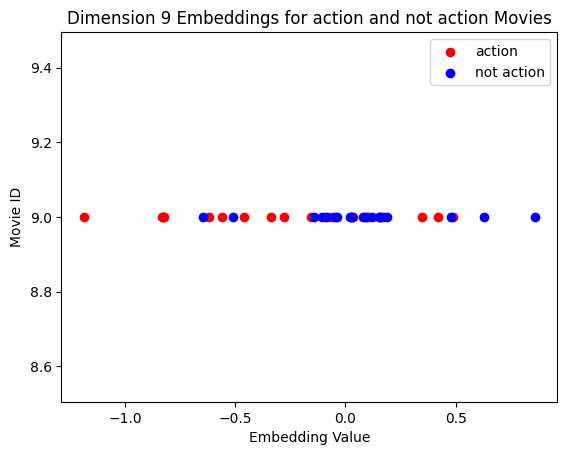

In [ ]:
plot_embs_one_genre(pmf.w_Item, moviesDF, 'action', 20)

I do not observe any discernible difference

### (b)

In [ ]:
def plot_embs_two_genres(embeddings, moviesDF, genres, sample_size):
  """
            INPUT:
                embeddings: numpy Array
                moviesDF: pandas DataFrame.
                          columns=['movieID',	'movieTitle',	'releaseDate	video','ReleaseDate',	'IMDbURL',...]
                genres: list of strings. (e.g., ['action', 'comedy'])
                sample_size: int


            OUTPUT:
                None

            NOTE: 1. You can read the file 'u.item' into a pandaas DataFrame for using as moviesDF
  """

  genre1 = genres[0]
  genre2 = genres[1]
  np.random.seed(3)
  genre1_movie_ids = np.random.choice(moviesDF[moviesDF[genre1] == 1]['movieID'].values, size = sample_size, replace=False)
  genre1_embeddings = embeddings[genre1_movie_ids]

  genre2_movie_ids = np.random.choice(moviesDF[moviesDF[genre2] == 1]['movieID'].values, size = sample_size, replace=False)
  genre2_embeddings = embeddings[genre2_movie_ids]

  all_ids = np.concatenate([genre1_movie_ids, genre2_movie_ids])
  index2id = {i:all_ids[i] for i in range(all_ids.shape[0])}

  all_embeddings = embeddings[all_ids]


  top_indices = np.argpartition(all_embeddings, -3, axis=0)[-3:]

  bottom_indices = np.argpartition(all_embeddings, 3, axis=0)[:3]

  v_offset = 20

  for i in range(embeddings.shape[1]):
    plt.close()
    plt.figure()
    plt.scatter(genre1_embeddings[:, i], np.full_like(genre1_movie_ids, i), c='red', label=f'{genre1}')
    plt.scatter(genre2_embeddings[:, i], np.full_like(genre2_movie_ids, i), c='blue', label=f'{genre2}')

    # for k, j in enumerate(top_indices[:, i]):
    #   y_offset = k * v_offset
    #   plt.annotate(moviesDF.loc[moviesDF['movieID'] == index2id[j], 'movieTitle'].values[0], (all_embeddings[j, i], i ), xytext=(-2*y_offset, 20+i+y_offset), textcoords='offset points', fontsize=8, color='black', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.3' ,color='black'))

    # for k, j in enumerate(bottom_indices[:, i]):
    #   y_offset = k * v_offset
    #   plt.annotate(moviesDF.loc[moviesDF['movieID'] == index2id[j], 'movieTitle'].values[0], (all_embeddings[j, i], i), xytext=(2*y_offset, -20-i-y_offset), textcoords='offset points', fontsize=8, color='black', arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=0.3', color='black'))

    plt.xlabel('Embedding Value')
    plt.ylabel('Movie ID')
    plt.legend()
    plt.title(f'Dimension {i} Embeddings for {genre1} and {genre2} Movies')
    plt.show()




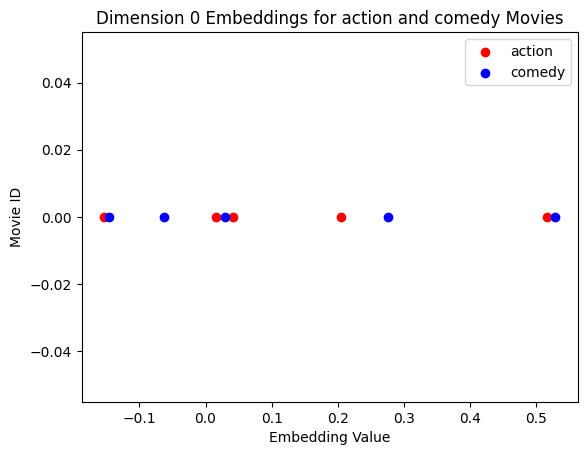

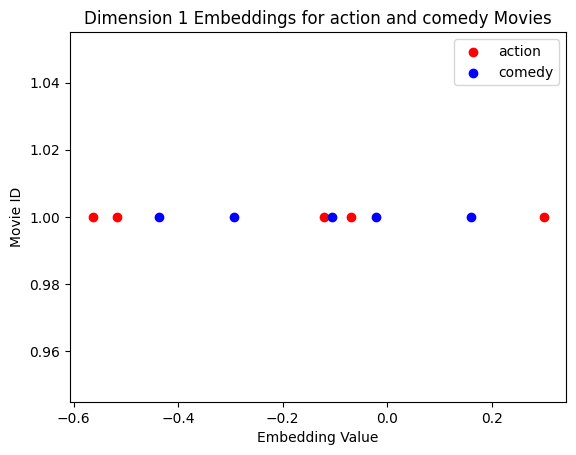

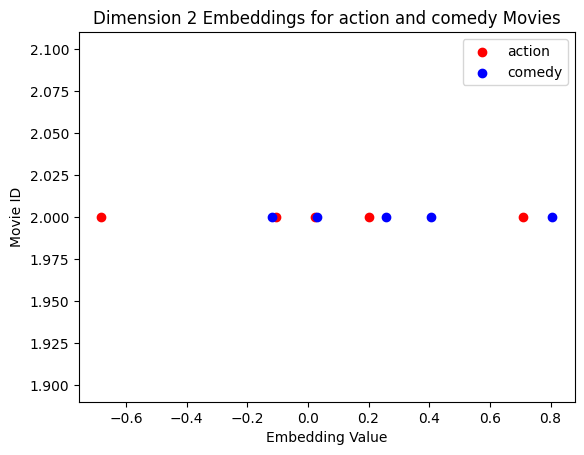

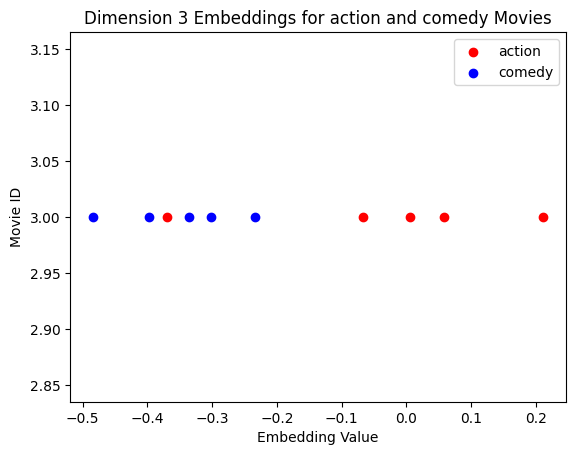

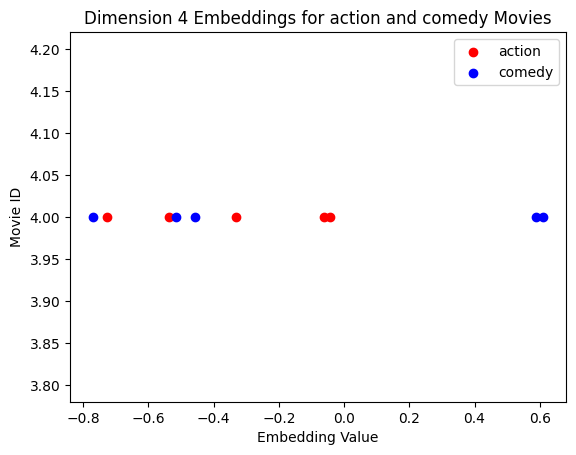

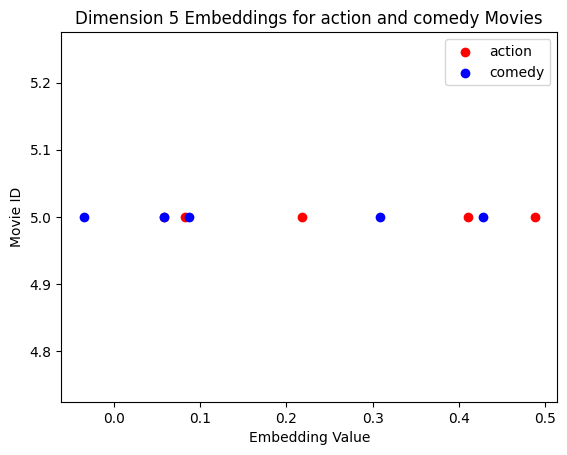

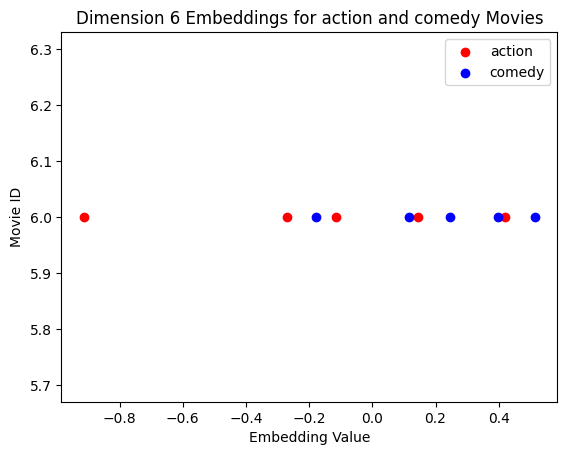

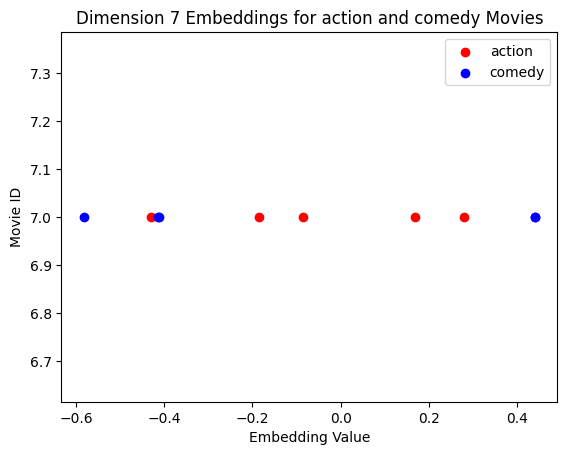

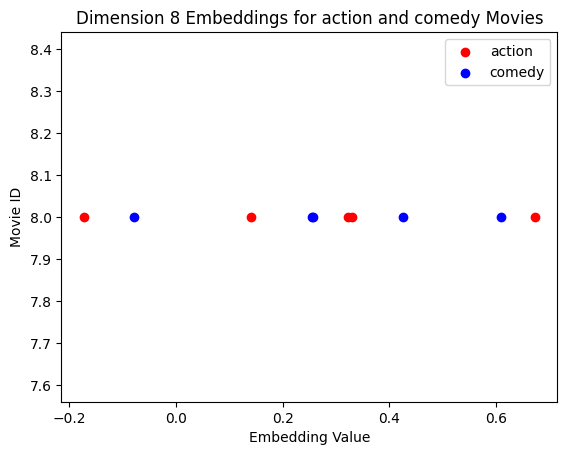

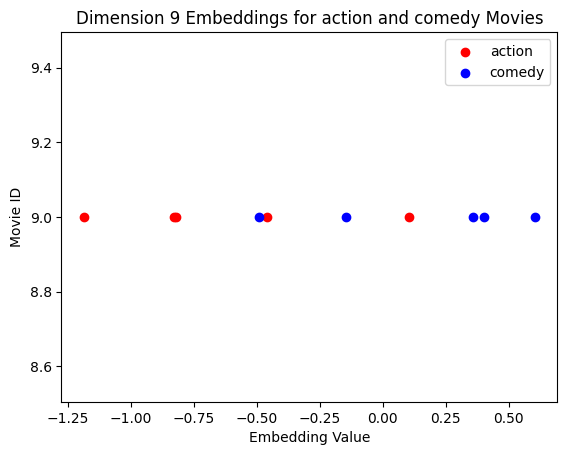

In [ ]:
plot_embs_two_genres(pmf.w_Item, moviesDF, ['action', 'comedy'], 5)

I see a clear distinction in  dimension 3. I would expect the embeddings for different genres to be different because the PMF algorithm should learn to produce different ratings for items depending on the nature of the item; and genre is one way to identify nature of item.

# Validation

In [ ]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [ ]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [ ]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [ ]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [ ]:
validatePopularityRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


### User Average Based Recommendation

In [ ]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    #useraverage_recsys = BaseLineRecSys('average_user_rating')
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [ ]:
validateUserAverRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [ ]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)

In [ ]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [ ]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)

In [ ]:
validateCustomizedSim()

### User-User Similarity Based Recommendation System

In [ ]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Framework error, please make sure you are using given yml file.")
        return

    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [ ]:
validateUUSimBasedRecSys()

<ipython-input-26-a03672383fef>:90: RuntimeWarning: invalid value encountered in divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)


### Item-Item Similarity Based Recommendation System

In [ ]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Framework error, please make sure you are using given yml file.")
        return

    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [ ]:
validateIISimBasedRecSys()

<ipython-input-26-a03672383fef>:116: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)


In [ ]:
def validatePMFRecSys(validation_df=validation_df):
    try:
        pmf = PMFRecSys()
        pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 1, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
        pmf.predict_all(rating_df, ROW_NUM, COL_NUM)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return

    try:
        pmf.predict_all(validation_df, ROW_NUM, COL_NUM)
        W_item, W_user = pmf.w_Item, pmf.w_User
        assert(W_item.shape == (COL_NUM+1, 10) and W_user.shape == (ROW_NUM+1, 10)),\
        "Shape of w_Item and W_User doesn't match predefined shape"
    except Exception as e:
        print(e)

In [ ]:
validatePMFRecSys(validation_df=validation_df)